<a href="https://colab.research.google.com/github/deepak-dee3/DEEP_LEARNING_PROJECT/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/deepak-dee3/DEEP_LEARNING_PROJECT.git

Cloning into 'DEEP_LEARNING_PROJECT'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.


In [ ]:
import os
import json

kaggle_credentails = json.load(open("kaggle.json"))
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [ ]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
 99% 728M/736M [00:07<00:00, 144MB/s]
100% 736M/736M [00:07<00:00, 109MB/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torchmetrics import Accuracy, ConfusionMatrix, Precision, Recall, F1Score

from tqdm import tqdm

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
def load_data():
    t = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
        ]
    )

    return datasets.ImageFolder(root="dataset", transform=t)

In [ ]:
from zipfile import ZipFile

In [ ]:
from PIL import Image

In [ ]:
with ZipFile("eye-diseases-classification.zip",'r') as zip_ref:
  zip_ref.extractall()

In [ ]:
!ls

dataset  eye-diseases-classification.zip  kaggle.json  sample_data


In [ ]:
dataset = load_data()

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 4217
    Root location: dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
           )

In [ ]:
NUMBER_OF_CLASSES = len(set(dataset.targets))


In [ ]:
print(f"Number of classes: {NUMBER_OF_CLASSES}")

Number of classes: 4


Label : cataract


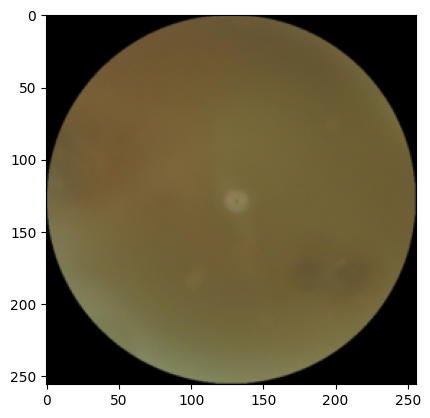

In [ ]:
def display_image(image, label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(image.permute(1, 2, 0))



display_image(*dataset[0])

In [ ]:
def train_test_split(dataset, train_size, random_state=42):
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    seed = torch.Generator().manual_seed(random_state)
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size], generator=seed
    )

    return train_dataset, test_dataset

In [ ]:
train_dataset, test_dataset = train_test_split(dataset, 0.8)


In [ ]:
batch_size = 32
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


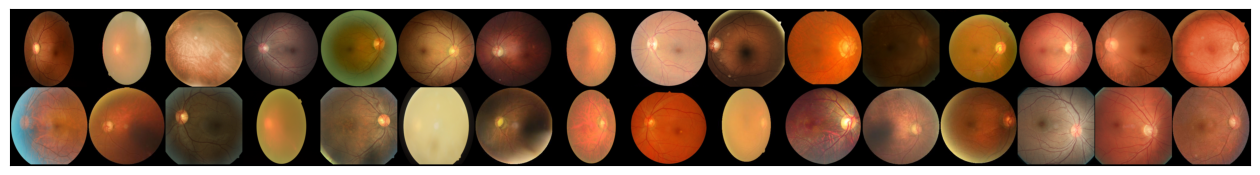

In [ ]:
def show_batch(data_loader):
    """Plot images grid of single batch"""
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


show_batch(train_dataloader)

In [ ]:
class CNN(nn.Module):
    def __init__(self, NUMBER_OF_CLASSES):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, NUMBER_OF_CLASSES),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.dense_layers(x)

        return x

In [ ]:
model = CNN(NUMBER_OF_CLASSES)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"

In [ ]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

    model.to(device)
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    accuracy = Accuracy(task="multiclass",
                        num_classes=NUMBER_OF_CLASSES).to(device)
    for epoch in range(epochs):
        train_loss = []
        for inputs, targets in tqdm(train_loader, desc=f'Training... Epoch: {epoch + 1}/{epochs}'):
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss
        train_loss = np.mean(train_loss)
        train_accuracy = accuracy(outputs, targets)

        test_loss = []
        for inputs, targets in tqdm(test_loader, desc=f'Validating... Epoch: {epoch + 1}/{epochs}'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss.append(loss.item())

        # Get test loss
        test_loss = np.mean(test_loss)
        # Test accuracy
        test_accuracy = accuracy(outputs, targets)

        # Save losses
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss

        print(f"Epoch {epoch+1}/{epochs}:")
        print(
            f"Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}")
        print(
            f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")
        print('-'*30)

    return train_losses, test_losses

In [ ]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_dataloader, test_dataloader, epochs=10
)

Validating... Epoch: 1/10: 100%|██████████| 27/27 [00:17<00:00,  1.52it/s]


Epoch 1/10:
Train Loss: 0.90, Train Accuracy: 0.92
Test Loss: 0.69, Test Accuracy: 0.50
------------------------------


Validating... Epoch: 2/10: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s]


Epoch 2/10:
Train Loss: 0.64, Train Accuracy: 0.77
Test Loss: 0.58, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 3/10: 100%|██████████| 27/27 [00:18<00:00,  1.45it/s]


Epoch 3/10:
Train Loss: 0.54, Train Accuracy: 0.92
Test Loss: 0.53, Test Accuracy: 0.83
------------------------------


Validating... Epoch: 4/10: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s]


Epoch 4/10:
Train Loss: 0.49, Train Accuracy: 0.46
Test Loss: 0.47, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 5/10: 100%|██████████| 27/27 [00:18<00:00,  1.43it/s]


Epoch 5/10:
Train Loss: 0.45, Train Accuracy: 0.85
Test Loss: 0.45, Test Accuracy: 1.00
------------------------------


Validating... Epoch: 6/10: 100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


Epoch 6/10:
Train Loss: 0.40, Train Accuracy: 0.92
Test Loss: 0.46, Test Accuracy: 0.83
------------------------------


Validating... Epoch: 7/10: 100%|██████████| 27/27 [00:18<00:00,  1.44it/s]


Epoch 7/10:
Train Loss: 0.40, Train Accuracy: 0.77
Test Loss: 0.41, Test Accuracy: 1.00
------------------------------


Validating... Epoch: 8/10: 100%|██████████| 27/27 [00:18<00:00,  1.44it/s]


Epoch 8/10:
Train Loss: 0.35, Train Accuracy: 0.92
Test Loss: 0.39, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 9/10: 100%|██████████| 27/27 [00:18<00:00,  1.46it/s]


Epoch 9/10:
Train Loss: 0.34, Train Accuracy: 1.00
Test Loss: 0.48, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 10/10: 100%|██████████| 27/27 [00:18<00:00,  1.44it/s]

Epoch 10/10:
Train Loss: 0.33, Train Accuracy: 0.69
Test Loss: 0.38, Test Accuracy: 0.92
------------------------------


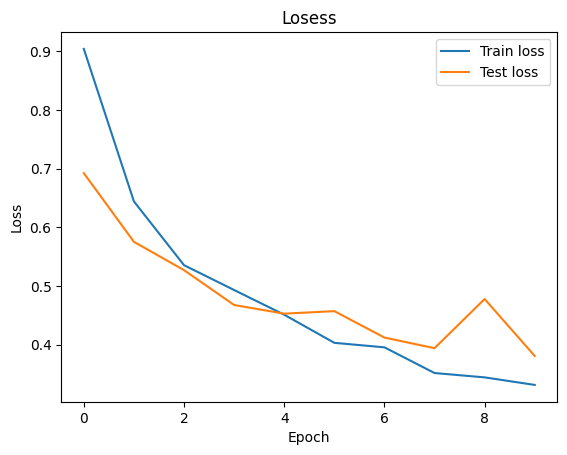

In [ ]:
plt.title("Losess")
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predections = torch.max(outputs, 1)

        y_pred_list.append(targets.cpu().numpy())
        y_true_list.append(predections.cpu().numpy())

targets = torch.tensor(np.concatenate(y_true_list))
preds = torch.tensor(np.concatenate(y_pred_list))

In [ ]:
confmat = ConfusionMatrix(task="multiclass", num_classes=NUMBER_OF_CLASSES)
cm = confmat(preds, targets)

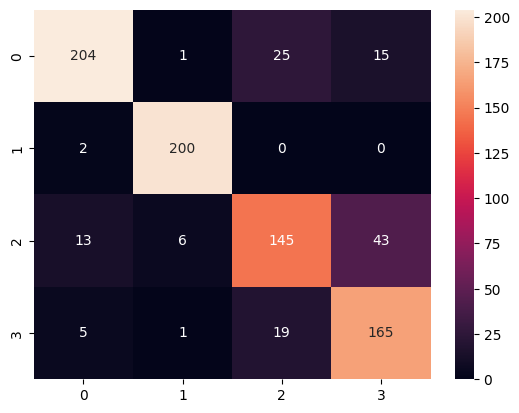

In [ ]:
sn.heatmap(cm, annot=True, fmt=".0f")
plt.show()

In [ ]:
accuracy = Accuracy(task="multiclass", num_classes=NUMBER_OF_CLASSES).to(device)
accuracy = accuracy(preds, targets)
print(f"Accuracy: {100 * accuracy:.2f}%")

Accuracy: 84.60%


In [ ]:
precision = Precision(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
precision = precision(preds, targets)
print(f"Precision: {100 * precision:.2f}%")

Precision: 84.60%


In [ ]:
recall = Recall(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
recall = recall(preds, targets)
print(f"Recall: {100 * recall:.2f}%")

Recall: 84.60%


In [ ]:
f1 = F1Score(task="multiclass", num_classes=NUMBER_OF_CLASSES)
f1 = f1(preds, targets)
print(f"F1 Score: {100 * f1:.2f}%")

F1 Score: 84.60%
